In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
df_selected = pd.read_csv('rusentiment_preselected_posts.csv')
df_random = pd.read_csv('rusentiment_random_posts.csv')
df_test = pd.read_csv('rusentiment_test.csv')

In [10]:
df_train = pd.concat((df_selected, df_random))

In [11]:
# Original code https://github.com/akutuzov/webvectors/blob/master/preprocessing/rus_preprocessing_udpipe.py
from ufal.udpipe import Model, Pipeline

#! wget http://rusvectores.org/static/models/udpipe_syntagrus.model
udpipe_filename = 'udpipe_syntagrus.model'
model = Model.load(udpipe_filename)
process_pipeline = Pipeline(model, 'tokenize', Pipeline.DEFAULT, Pipeline.DEFAULT, 'conllu')

def tag_ud(pipeline, text='Text in string format', pos=True):
    # если частеречные тэги не нужны (например, их нет в модели), выставьте pos=False
    # в этом случае на выход будут поданы только леммы

    # обрабатываем текст, получаем результат в формате conllu:
    processed = pipeline.process(text)

    # пропускаем строки со служебной информацией:
    content = [l for l in processed.split('\n') if not l.startswith('#')]

    # извлекаем из обработанного текста лемму и тэг
    tagged = [w.split('\t')[2].lower() + '_' + w.split('\t')[3] for w in content if w]
    result = []
    for t in tagged:
        if (len(t.split('_')) == 2):
            lemma, tag = t.split('_')
            # убираем числительные и все знаки пунктуации кроме скобок
            if tag == 'NUM' or (tag == 'PUNCT' and lemma not in ['(', ')']):
                continue
            if pos:
                result.append(lemma + '_' + tag)
            else:
                result.append(lemma)
    return result

In [12]:
df_train['lemmatized_tokens'] = df_train.apply(lambda x: tag_ud(process_pipeline, x['text'], pos=False), axis=1)
df_test['lemmatized_tokens'] = df_test.apply(lambda x: tag_ud(process_pipeline, x['text'], pos=False), axis=1)

df_train['lemmatized_text'] = df_train['lemmatized_tokens'].str.join(' ')
df_test['lemmatized_text'] = df_test['lemmatized_tokens'].str.join(' ')

df_train = df_train[~df_train.lemmatized_text.isnull()]
df_test = df_test[~df_test.lemmatized_text.isnull()]

In [13]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

X_train = df_train['lemmatized_text'].values
X_test = df_test['lemmatized_text'].values

y_train  = le.fit_transform(df_train['label'].values)
y_test  = le.transform(df_test['label'].values) 

In [14]:
%%time
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from scipy.stats import expon


exp = expon(scale=2)
NB_pipeline = Pipeline([('tfidf', TfidfVectorizer()), ('multiNB', MultinomialNB(class_prior=None))])
param_grid = {'tfidf__ngram_range':[(1,2), (1,1)],
              'tfidf__sublinear_tf':[True, False],
              'tfidf__min_df':np.arange(2,5,1),
              'multiNB__alpha': exp.rvs(size=10), 
              'multiNB__fit_prior':[True, False]
              }

skf = StratifiedKFold(n_splits=5, random_state=42)
gr = GridSearchCV(NB_pipeline, param_grid, cv=skf, verbose=0)
gr_model = gr.fit(X_train, y_train)


CPU times: user 58min 57s, sys: 31.5 s, total: 59min 29s
Wall time: 51min 33s


In [15]:
result = gr_model.cv_results_

In [ ]:
rows = list ()
for model in result['params']:
    row = []
    for key, val in model.items():
        if key=='classifier':
            v_str = (val.__str__())
            row.append(v_str [ : v_str.find('(')])
        else:
            param = key.__str__()
            param = param [ param.find('__')+2 :]
            row.append(param + ' = ' + val.__str__())
    rows.append(row)

df = pd.DataFrame(rows)
df['score'] = result['mean_test_score']
df['time'] = result['mean_fit_time']

df = df.sort_values(by=['score'], ascending=False)

In [17]:
df[1:20]

,0,1,2,3,4,score,time
173,alpha = 0.21970331388934286,fit_prior = True,min_df = 3,"ngram_range = (1, 2)",sublinear_tf = False,0.582182,2.079544
169,alpha = 0.21970331388934286,fit_prior = True,min_df = 2,"ngram_range = (1, 2)",sublinear_tf = False,0.581437,1.933962
168,alpha = 0.21970331388934286,fit_prior = True,min_df = 2,"ngram_range = (1, 2)",sublinear_tf = True,0.581048,2.009645
177,alpha = 0.21970331388934286,fit_prior = True,min_df = 4,"ngram_range = (1, 2)",sublinear_tf = False,0.580870,2.298541
176,alpha = 0.21970331388934286,fit_prior = True,min_df = 4,"ngram_range = (1, 2)",sublinear_tf = True,0.580729,2.034982
48,alpha = 0.12162256502136387,fit_prior = True,min_df = 2,"ngram_range = (1, 2)",sublinear_tf = True,0.580091,1.889471
49,alpha = 0.12162256502136387,fit_prior = True,min_df = 2,"ngram_range = (1, 2)",sublinear_tf = False,0.579843,1.916305
53,alpha = 0.12162256502136387,fit_prior = True,min_df = 3,"ngram_range = (1, 2)",sublinear_tf = False,0.579382,1.926445
52,alpha = 0.12162256502136387,fit_prior = True,min_df = 3,"ngram_range = (1, 2)",sublinear_tf = True,0.578957,1.845136
200,alpha = 0.562308750517385,fit_prior = True,min_df = 4,"ngram_range = (1, 2)",sublinear_tf = True,0.578496,2.015164


fit_prior = True, равно как и ngram_range=(1,2) дают стабильный прирост точности. Минимальное количество документов варьируется от 2 до 4. В то же время варьирование alpha и sublinear_tf не дают значительного прироста качества предсказывания.

In [18]:
gr_model.best_params_, gr_model.best_score_

({'multiNB__alpha': 0.21970331388934286,
  'multiNB__fit_prior': True,
  'tfidf__min_df': 3,
  'tfidf__ngram_range': (1, 2),
  'tfidf__sublinear_tf': True},
 0.5829966687929691)

In [20]:
best_pipe = Pipeline([('tfidf',TfidfVectorizer(ngram_range=(1,2), min_df=3, sublinear_tf=True)),
                              ('multiNB', MultinomialNB(alpha=0.21970331388934286, fit_prior = True))])

In [21]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

best_pipe.fit(X_train, y_train)
y_pred = best_pipe.predict(X_test)
def score_model(y_pred, y_true):
    average = 'weighted'
    f1 = f1_score(y_true, y_pred, average=average)
    precision = precision_score(y_true, y_pred, average=average)
    recall = recall_score(y_true, y_pred, average=average)
    return f1, precision, recall

f1, precision, recall = score_model(y_pred,y_test)
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'f1-score: {f1:.4f}')

Precision: 0.6408
Recall: 0.6593
f1-score: 0.6331


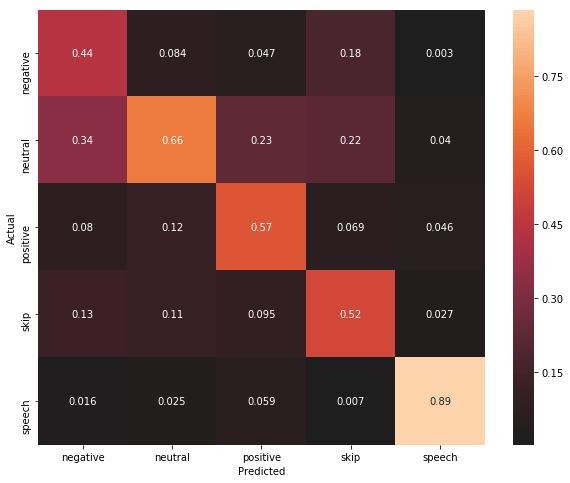

In [22]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat_ratios = np.round(conf_mat / np.sum(conf_mat, axis=0),3)
fig, ax = plt.subplots(figsize=(10,8))

labels = sorted(list(set(le.inverse_transform(y_pred))))
sns.heatmap(conf_mat_ratios, annot=True, center=0, xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [23]:
y_pred_labels = le.inverse_transform(y_pred)
y_test_labels = le.inverse_transform(y_test)

results = pd.DataFrame({'text':df_test.text, 'lemmatized_tokens':df_test.lemmatized_tokens,'predicted':y_pred_labels, 'actual':y_test_labels})
errors = results[results.predicted != results.actual]

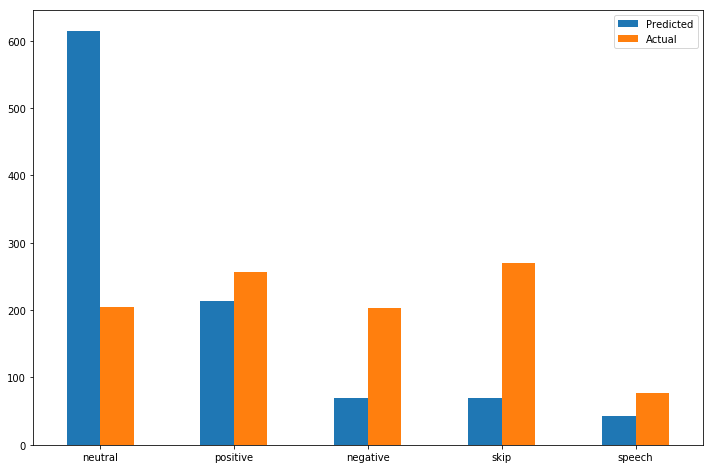

In [24]:
fig, ax = plt.subplots(figsize=(12, 8))
freq = pd.DataFrame({'Predicted': errors.predicted.value_counts(), 'Actual':errors.actual.value_counts()})
freq.sort_values(by='Predicted', ascending=False).plot.bar(rot=0, ax=ax);

In [25]:
errors

,text,lemmatized_tokens,predicted,actual
3,Мы просто с [id12210212|Елисеем] психанули )...,"[мы, просто, с, id12210212|елисей, психануть, ...",positive,skip
5,Наши красавцы. 1:3 в первом периоде и 7:3 в ит...,"[наш, красавец, в, первый, период, и, в, итог]",neutral,positive
8,"нельзя общаться с людьми, которые нуждаются в ...","[нельзя, общаться, с, человек, который, нуждат...",neutral,negative
17,"Я не писал такое оскобление всем!!!!\nМеня, ви...","[я, не, писать, такой, оскоблений, все, я, вид...",neutral,skip
18,...и так начало мини отпуска))И новых приключе...,"[...ь, так, начинать, минять, отпуск, ), ), и,...",neutral,positive
19,Кинул в чс обиделся холоп понял что недостоин ...,"[кидать, в, чс, обижаться, холоп, понимать, чт...",neutral,negative
21,Лучше бы у Тани не было никакого оргазма: услы...,"[хороший, бы, в, таня, не, быть, никакой, орга...",neutral,skip
25,"по кругу, твою подругу КСЮХУ....))))))ахахахаахах","[по, круг, твой, подруга, ксюх, ), ), ), ), ),...",positive,skip
26,без тебя_(,"[без, (]",neutral,negative
27,я прыгнул в бездну из уюта пора готовиться к з...,"[я, прыгнуть, в, бездна, из, уют, пора, готови...",neutral,negative
